# Glaucoma Segmentation


## Imports

In [1]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from collections import defaultdict
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm

from models import *
from training import *
from utils import *

## Setup

In [2]:
IMAGE_DIR = '../data/ORIGA/Images_Cropped'
MASK_DIR = '../data/ORIGA/Masks_Cropped'
LOGS_DIR = '../logs/'
CHECKPOINT_DIR = '../checkpoints/'
IMAGE_HEIGHT, IMAGE_WIDTH = 128, 128
BATCH_SIZE = 4
LEARNING_RATE = 1e-4
EPOCHS = 3
LAYERS = [32, 64, 128, 256, 512]
EARLY_STOPPING_PATIENCE = 10
SAVE_INTERVAL = 10
NUM_WORKERS = 4
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
PIN_MEMORY = True if DEVICE == 'cuda' else False
LOAD_MODEL = ''
USE_WANDB = False
DEEP_SUPERVISION = False

os.makedirs(LOGS_DIR, exist_ok=True)
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

print(f'PyTorch version: {torch.__version__}')
print(f'Using device: {DEVICE}')

PyTorch version: 2.0.1+cu118
Using device: cuda


## Dataset

Image shape: torch.Size([1, 3, 128, 128])
Mask shape: torch.Size([1, 128, 128])
Unique values and their counts in mask: {0: 5922, 1: 5486, 2: 4976}


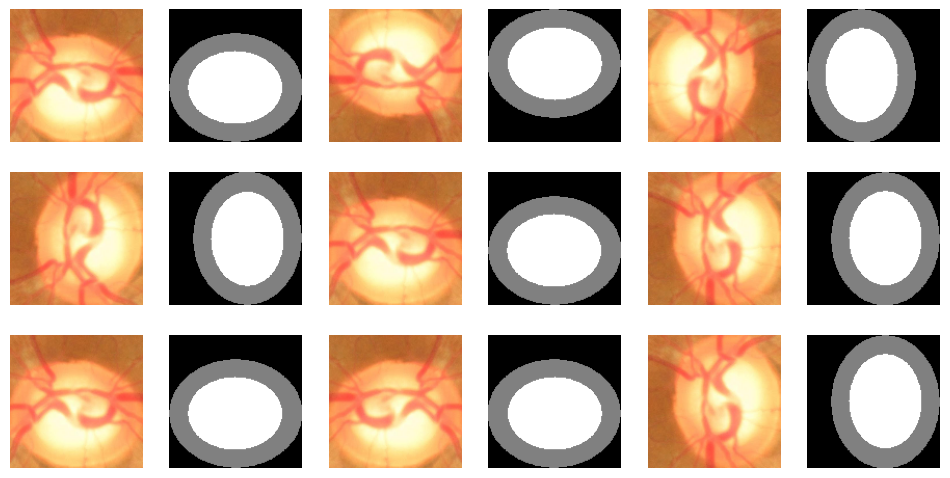

In [3]:
example_ds = OrigaDataset(IMAGE_DIR, MASK_DIR, os.listdir(IMAGE_DIR)[:1], A.Compose([
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=1.0),  # rotate by 0, 90, 180, or 270 degrees
    A.Rotate(limit=30, p=0.33, border_mode=cv.BORDER_CONSTANT),
    A.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0]),
    ToTensorV2(),
]))
example_loader = DataLoader(example_ds, batch_size=1, shuffle=True)

example_image, example_mask = next(iter(example_loader))
print(f'Image shape: {example_image.shape}')
print(f'Mask shape: {example_mask.shape}')

unique, counts = np.unique(example_mask, return_counts=True)
print(f'Unique values and their counts in mask: {dict(zip(unique, counts))}')

# Plot example augmented images and masks
fig, ax = plt.subplots(3, 6, figsize=(12, 6))
ax = ax.ravel()
for i in range(0, 3 * 6, 2):
    batch = next(iter(example_loader))
    images, masks = batch
    image, mask = images[0], masks[0]
    image = image.permute(1, 2, 0).numpy()
    mask = mask.numpy()
    ax[i].imshow(image)
    ax[i].axis('off')
    ax[i + 1].imshow(mask, cmap='gray')
    ax[i + 1].axis('off')
plt.show()

In [4]:
train_transform = A.Compose([
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=1.0),
    # A.Rotate(limit=30, p=0.25, border_mode=cv.BORDER_CONSTANT),
    # A.Normalize(mean=ORIGA_MEANS, std=ORIGA_STDS),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    # A.Normalize(mean=ORIGA_MEANS, std=ORIGA_STDS),
    ToTensorV2()
])

train_ds, val_ds, test_ds = load_origa(
    IMAGE_DIR, MASK_DIR, train_transform, val_transform, val_transform,
    train_size=0.7, val_size=0.15, test_size=0.15,
    # train_size=0.01, val_size=0.01, test_size=0.98,
)

print(f'Train size: {len(train_ds)}')
print(f'Validation size: {len(val_ds)}')
print(f'Test size: {len(test_ds)}')

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, pin_memory=PIN_MEMORY, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, pin_memory=PIN_MEMORY, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, pin_memory=PIN_MEMORY, num_workers=NUM_WORKERS)

Train size: 454
Validation size: 98
Test size: 98


## Model

In [5]:
# initialize model, loss, optimizer, scheduler, scaler, ...
model = UNet(in_channels=3, out_channels=3, features=LAYERS).to(DEVICE)
# model = UNetPlusPlus(in_channels=3, out_channels=3, features=LAYERS, deep_supervision=DEEP_SUPERVISION).to(DEVICE)
# model = UNet3Plus(in_channels=3, out_channels=3, features=LAYERS, deep_supervision=DEEP_SUPERVISION).to(DEVICE)

# model = AttentionUNet(in_channels=3, out_channels=3, features=LAYERS).to(DEVICE)
# model = InceptionUNet(in_channels=3, out_channels=3, features=LAYERS).to(DEVICE)

# model = ResUNet(in_channels=3, out_channels=3, features=LAYERS).to(DEVICE)
# model = RUNet(in_channels=3, out_channels=3, features=LAYERS).to(DEVICE)
# model = R2UNet(in_channels=3, out_channels=3, features=LAYERS).to(DEVICE)

# model = SqueezeUNet(in_channels=3, out_channels=3, features=LAYERS).to(DEVICE)

# model = R2AttentionUNet(in_channels=3, out_channels=3, features=LAYERS).to(DEVICE)
# model = R2UNetPlusPlus(in_channels=3, out_channels=3, features=LAYERS).to(DEVICE)

# model = ResAttentionUNetPlusPlus(in_channels=3, out_channels=3, features=LAYERS).to(DEVICE)
# model = RefUNet3PlusCBAM(in_channels=3, out_channels=3, features=LAYERS).to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# criterion = nn.CrossEntropyLoss()  # softmax layer is already included inside nn.CrossEntropyLoss()
criterion = DiceLoss(num_classes=3, device=DEVICE, class_weights=[1.0, 1.0, 1.0])
# criterion = IoULoss(num_classes=3, device=DEVICE, class_weights=[1.0, 1.0, 1.0])
# criterion = FocalLoss(alpha=0.25, gamma=2)
# criterion = TverskyLoss(num_classes=3, alpha=0.5, beta=0.5, class_weights=[1.0, 1.0, 1.0], device=DEVICE)
# criterion = FocalTverskyLoss(num_classes=3, alpha=0.5, beta=0.5, gamma=1.0,
#                              class_weights=[1.0, 1.0, 1.0], device=DEVICE)

# scheduler = None
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=5, verbose=True)

scaler = None
# scaler = torch.cuda.amp.GradScaler()

if LOAD_MODEL:
    load_checkpoint(LOAD_MODEL, model, optimizer)

## Training

In [ ]:
hist = train_multiclass(
    model, criterion, optimizer, EPOCHS, DEVICE, train_loader, val_loader, scheduler, scaler,
    save_interval=SAVE_INTERVAL, early_stopping_patience=EARLY_STOPPING_PATIENCE,
    log_to_wandb=USE_WANDB, log_dir=LOGS_DIR, checkpoint_dir=CHECKPOINT_DIR,
    save_best_model=False,
)

In [ ]:
# Plot metrics
used_metrics = sorted([m[6:] for m in hist.keys() if m.startswith('train_')])
fig, ax = plt.subplots(4, 4, figsize=(14, 8))
ax = ax.ravel()

for i, metric in enumerate(used_metrics):
    ax[i].plot(hist[f'train_{metric}'], label=f'train')
    ax[i].plot(hist[f'val_{metric}'], label=f'val')
    ax[i].set_title(metric[0].upper() + metric[1:].replace('_', ' '))
    if metric != 'loss':
        ax[i].set_ylim(top=1)
    ax[i].legend()

for ax in ax[len(used_metrics):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

## Testing

In [8]:
results = evaluate(model, criterion, DEVICE, test_loader)

Evaluating: 100%|██████████| 25/25 [00:04<00:00,  5.29it/s, accuracy_OC=0.92, accuracy_OD=0.949, dice_OC=0.857, dice_OD=0.964, iou_OC=0.752, iou_OD=0.932, loss=0.227, precision_OC=0.83, precision_OD=0.967, sensitivity_OC=0.896, sensitivity_OD=0.962, specificity_OC=0.934, specificity_OD=0.918]  


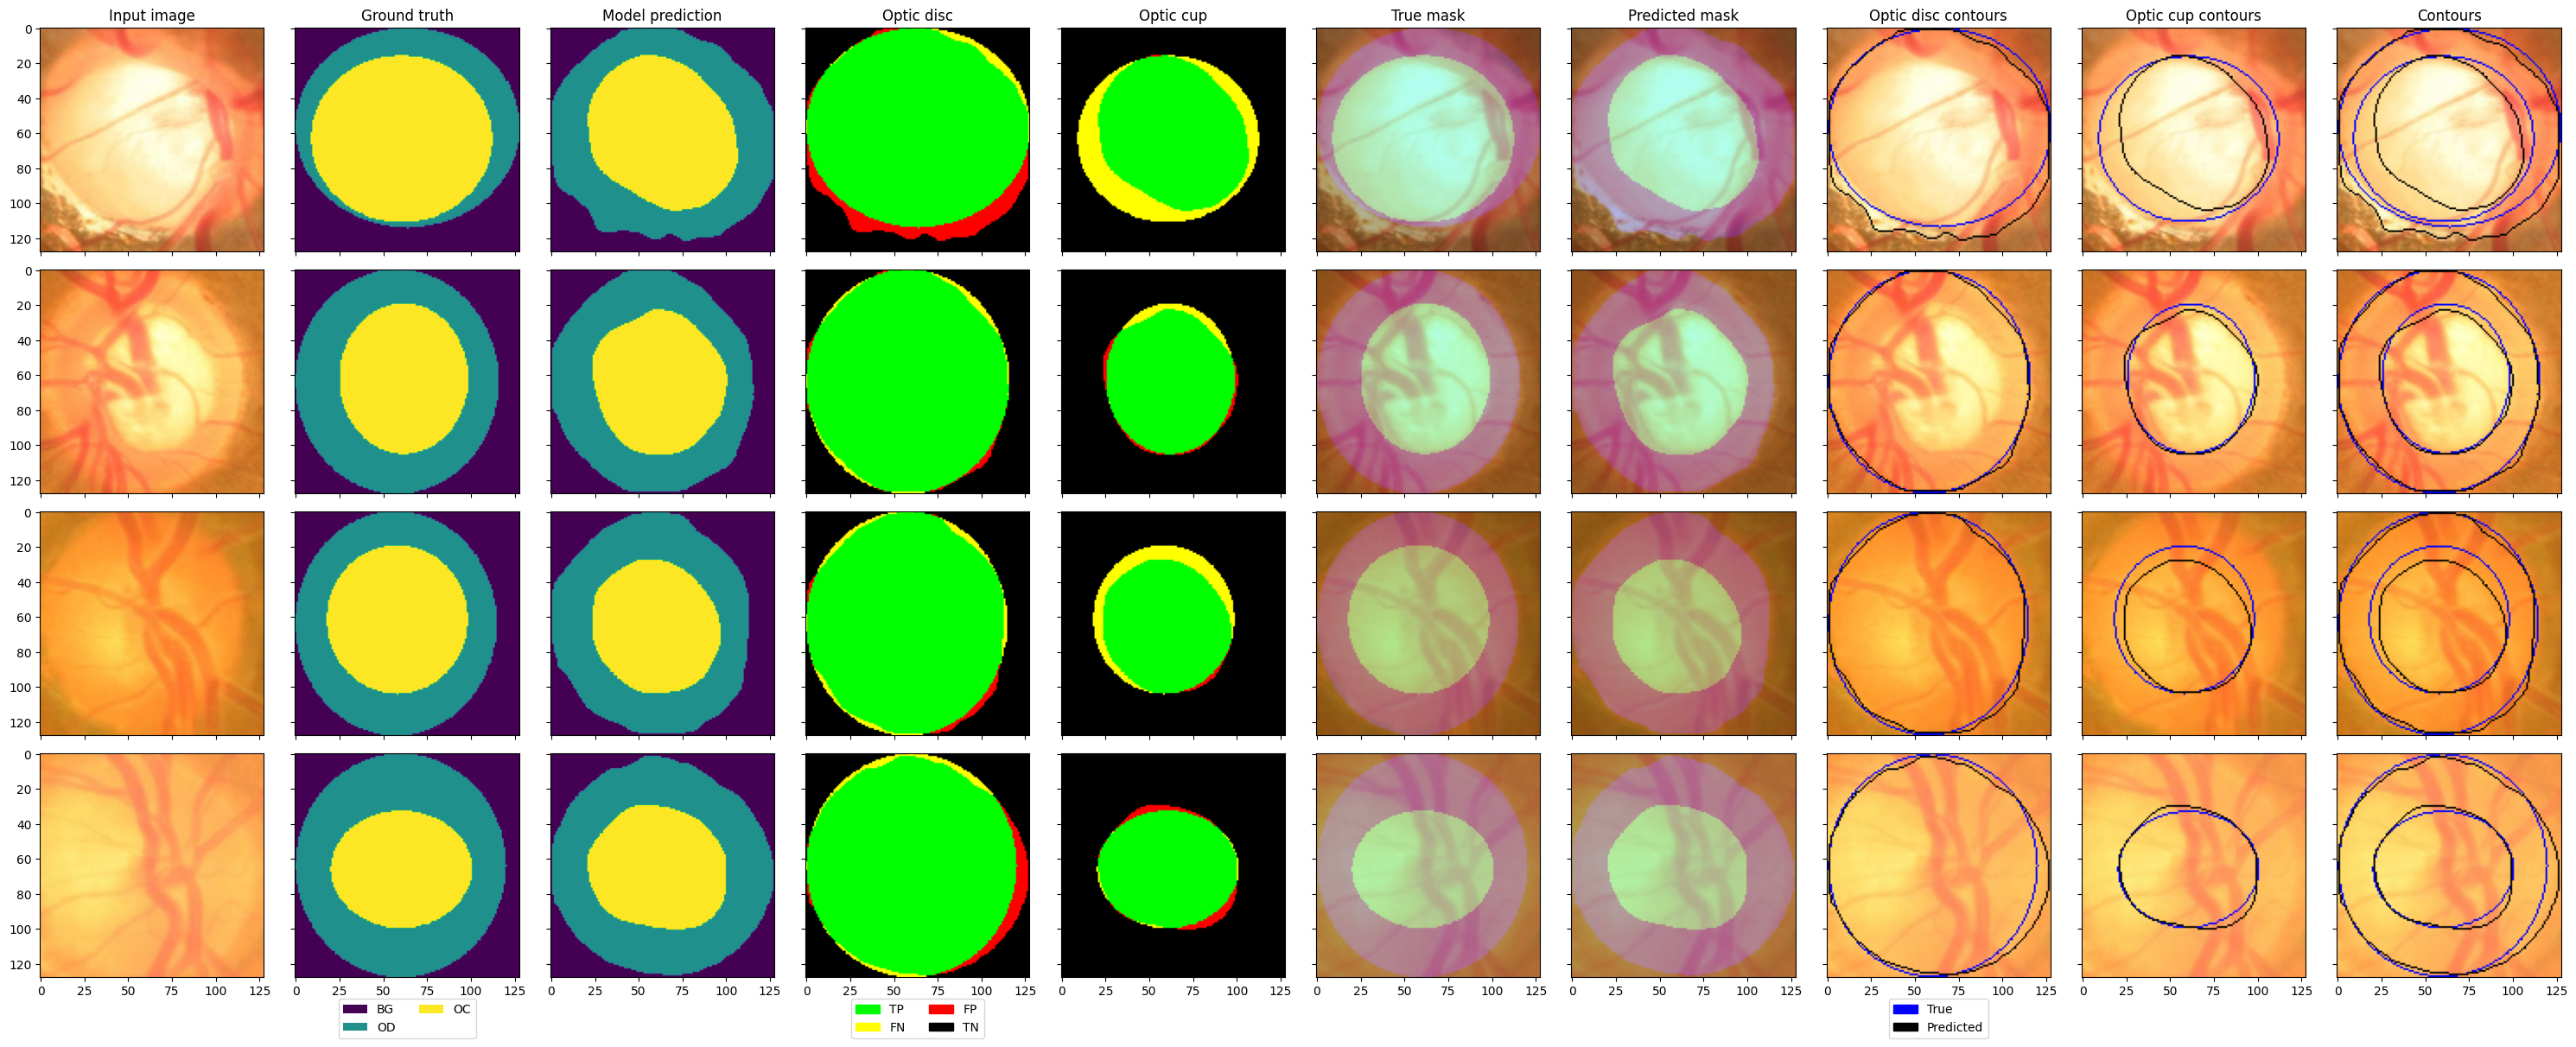

In [9]:
plot_results_from_loader(test_loader, model, DEVICE, types='all', n_samples=4, save_path=f'{LOGS_DIR}/evaluation.png')

## Work in progress

In [10]:
# torch.save(model.state_dict(), CHECKPOINT_DIR + 'model.pth')

checkpoint = torch.load(CHECKPOINT_DIR + 'model.pth')
model = UNet(in_channels=3, out_channels=3).to(DEVICE)
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [ ]:
# TODO: test new Dice Loss
model = UNet(in_channels=3, out_channels=1).to(DEVICE)
loss = DiceLoss(num_classes=1)
# loss = GeneralizedDice(num_classes=1)
# loss = IoULoss(num_classes=1)
# loss = FocalLoss(num_classes=1)
# loss = TverskyLoss(num_classes=1)
# loss = FocalTverskyLoss(num_classes=1)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

for epoch in range(5):
    acc_loss = 0
    for images, masks in val_loader:
        images = images.float().to(DEVICE)
        masks = masks.long().to(DEVICE)
        masks = torch.where(masks > 0, torch.tensor(1).to(DEVICE), torch.tensor(0).to(DEVICE))

        outputs = model(images)
        loss_value = loss(outputs, masks)
        acc_loss += loss_value.item()

        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()

    # plot example
    images = images.cpu().numpy()
    masks = masks.cpu().numpy()
    # probs = F.softmax(outputs, dim=1)
    # preds = torch.argmax(probs, dim=1).cpu().numpy()
    probs = torch.sigmoid(outputs)
    preds = (probs > 0.5).float().cpu().numpy().transpose(0, 2, 3, 1)

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(images[0].transpose(1, 2, 0) / 255.0)
    ax[1].imshow(masks[0])
    ax[2].imshow(preds[0])
    plt.show()

    print(f'Epoch {epoch + 1} loss:', acc_loss / len(val_loader))


In [123]:
from scipy.ndimage import distance_transform_edt


class HausdorffLoss(nn.Module):
    def __init__(self, num_classes=3, ignore_index=0):
        super(HausdorffLoss, self).__init__()
        self.num_classes = num_classes
        self.ignore_index = ignore_index
        self.alpha = 2

    def forward(self, logits, target):
        probs = F.softmax(logits, dim=1)
        preds = torch.argmax(probs, dim=1)
        target_one_hot = F.one_hot(target, num_classes=self.num_classes).permute(0, 3, 1, 2).float()

        preds_od = preds >= 1
        preds_oc = preds == 2

        target_od = target >= 1
        target_oc = target == 2

        print(f'{probs.shape = }')
        print(f'{preds.shape = }')
        print(f'{target.shape = }')
        print(f'{target_one_hot.shape = }')

        print('Preds distance map OD')
        preds_dist_od = self.compute_distance_map(preds_od)
        print(f'{preds_dist_od.shape = }')

        print('Target distance map OC')
        preds_dist_oc = self.compute_distance_map(preds_oc)
        print(f'{preds_dist_oc.shape = }')

        print('Target distance map OD')
        target_dist_od = self.compute_distance_map(target_od)
        print(f'{target_dist_od.shape = }')

        print('Target distance map OC')
        target_dist_oc = self.compute_distance_map(target_oc)
        print(f'{target_dist_oc.shape = }')

        error = torch.pow(preds - target, 2)
        print(f'{error.shape = }')
        distance_od = preds_dist_od ** self.alpha + target_dist_od ** self.alpha
        print(f'{distance_od.shape = }')
        distance_oc = preds_dist_oc ** self.alpha + target_dist_oc ** self.alpha
        print(f'{distance_oc.shape = }')

        loss_od = error * distance_od
        print(f'{loss_od.shape = }')
        loss_oc = error * distance_oc
        print(f'{loss_oc.shape = }')

        loss = loss_od.mean() + loss_oc.mean()
        print(f'{loss.shape = }')
        return loss

        # forward_hd = torch.max(pred_dist * target_class)
        # backward_hd = torch.max(target_dist * pred_class)
        #
        # hausdorff_dist = torch.pow(forward_hd, self.alpha) + torch.pow(backward_hd, self.alpha)
        # hausdorff_loss = torch.abs(pred_class - target_class) * hausdorff_dist
        #
        # loss = hausdorff_loss.mean()
        #
        # loss /= (self.num_classes - 1)

    def compute_distance_map(self, masks):
        masks_np = masks.detach().cpu().numpy().astype(np.float32)
        dist_map = np.zeros_like(masks_np, dtype=np.float32)

        n_samples = masks_np.shape[0]
        for i in range(n_samples):
            fg_edt = distance_transform_edt(masks_np[i])
            bg_edt = distance_transform_edt(1 - masks_np[i])
            dist_map[i] = fg_edt + bg_edt

        _, ax = plt.subplots(2, masks_np.shape[0], figsize=(10, 5))
        for i in range(dist_map.shape[0]):
            ax[0, i].imshow(masks_np[i])
            ax[1, i].imshow(dist_map[i])
        plt.show()

        print(f'{masks_np.shape = }')
        print(f'{dist_map.shape = }')

        return torch.from_numpy(dist_map).to(masks.device)


class HausdorffDTLoss(nn.Module):

    def __init__(self, alpha=2.0, **kwargs):
        super(HausdorffDTLoss, self).__init__()
        self.alpha = alpha

    @torch.no_grad()
    def distance_field(self, img: np.ndarray, thresh=1) -> np.ndarray:
        field = np.zeros_like(img)

        for i in range(len(img)):
            fg_mask = img[i] >= thresh

            if fg_mask.any():
                bg_mask = ~fg_mask

                fg_dist = distance_transform_edt(fg_mask)
                bg_dist = distance_transform_edt(bg_mask)

                field[i] = fg_dist + bg_dist

        # _, ax = plt.subplots(2, img.shape[0], figsize=(10, 5))
        # for i in range(field.shape[0]):
        #     ax[0, i].imshow(img[i])
        #     ax[1, i].imshow(field[i])
        # plt.show()

        return field

    def forward(self, pred: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        """
        Uses one binary channel: 1 - fg, 0 - bg
        pred: (b, 1, x, y, z) or (b, 1, x, y)
        target: (b, 1, x, y, z) or (b, 1, x, y)
        """
        pred = torch.softmax(pred, dim=1)

        p1 = pred[:, 1] + pred[:, 2]
        p2 = pred[:, 2]
        pred1_dt = torch.from_numpy(self.distance_field(p1.detach().cpu().numpy(), 0.5)).float().to(pred.device)
        pred2_dt = torch.from_numpy(self.distance_field(p2.detach().cpu().numpy(), 0.5)).float().to(pred.device)
        target1_dt = torch.from_numpy(self.distance_field(target.detach().cpu().numpy(), 0.5)).float().to(pred.device)
        target2_dt = torch.from_numpy(self.distance_field(target.detach().cpu().numpy(), 1.5)).float().to(pred.device)

        pred_error1 = (pred[:, 1] - target) ** 2
        distance1 = pred1_dt ** self.alpha + target1_dt ** self.alpha
        dt_field1 = pred_error1 * distance1

        pred_error2 = (pred[:, 2] - target) ** 2
        distance2 = pred2_dt ** self.alpha + target2_dt ** self.alpha
        dt_field2 = pred_error2 * distance2

        dt_field = dt_field1 + dt_field2

        return dt_field.mean()



images.shape = torch.Size([4, 3, 128, 128])
masks.shape = torch.Size([4, 128, 128])
logits.shape = torch.Size([4, 3, 128, 128])



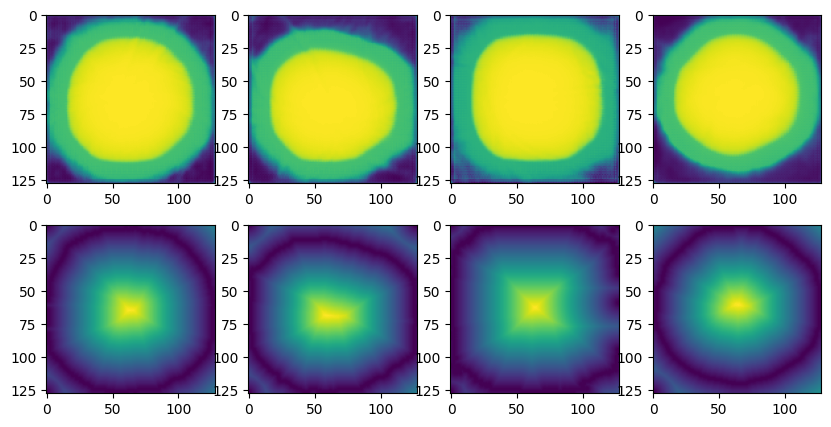

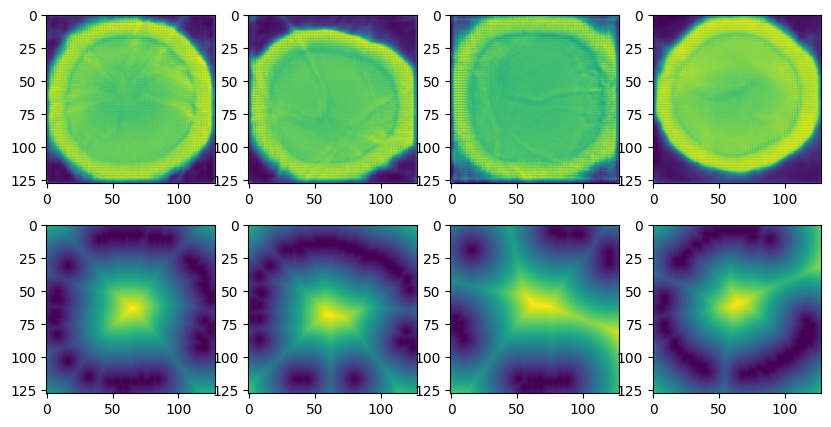

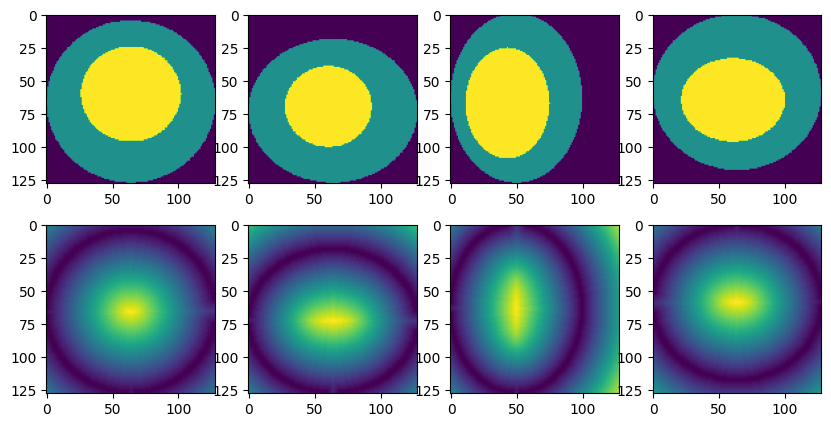

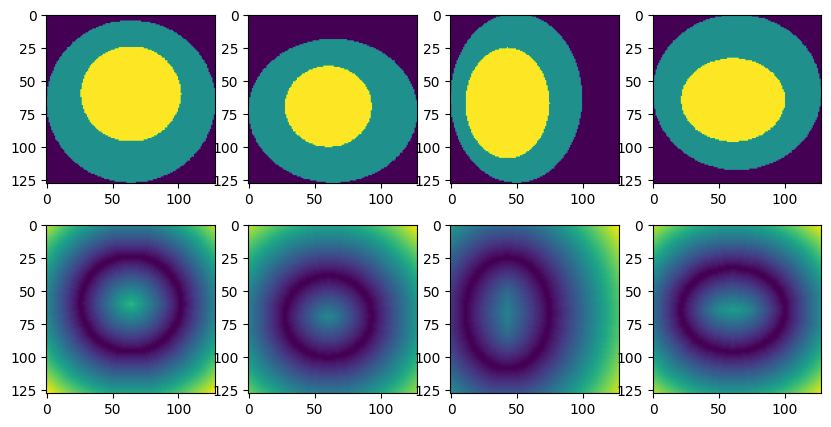

Hausdorff loss: 2271.535888671875, loss.shape = torch.Size([])


In [122]:
# hausdorff_loss = HausdorffLoss()
hausdorff_loss = HausdorffDTLoss()
ce_loss = nn.CrossEntropyLoss()

# images, masks = next(iter(train_loader))
# images = images.float().to(DEVICE)
# masks = masks.long().to(DEVICE)

print(f'{images.shape = }')
print(f'{masks.shape = }')

logits = model(images)
print(f'{logits.shape = }')
print()
loss = hausdorff_loss(logits, masks)
print(f'Hausdorff loss: {loss.item()}, {loss.shape = }')

loss.backward()


In [ ]:
class BoundaryLoss(nn.Module):
    def __init__(self):
        super(BoundaryLoss, self).__init__()

    def forward(self, logits, target):
        probs = F.softmax(logits, dim=1)
        predictions = torch.argmax(probs, dim=1)

        # Compute the boundary maps for both prediction and target
        pred_boundary = self.compute_boundary_map(predictions)
        target_boundary = self.compute_boundary_map(target)

        # Calculate the boundary loss
        loss = torch.mean((pred_boundary - target_boundary) ** 2)

        return loss

    def compute_boundary_map(self, mask):
        # Define the horizontal and vertical sobel filters
        sobel_x = torch.Tensor([[1, 0, -1], [2, 0, -2], [1, 0, -1]]).to(DEVICE)
        sobel_y = torch.Tensor([[1, 2, 1], [0, 0, 0], [-1, -2, -1]]).to(DEVICE)

        # Compute the horizontal and vertical gradients using the sobel filters
        G_x = F.conv2d(mask, sobel_x, padding=1)
        G_y = F.conv2d(mask, sobel_y, padding=1)

        # Calculate the magnitude of the gradient
        G = torch.sqrt(torch.pow(G_x, 2) + torch.pow(G_y, 2))

        # Normalize the gradient magnitude
        G = G / torch.max(G)

        return G

In [ ]:
model = UNet(in_channels=3, out_channels=3, features=LAYERS).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
cross_entropy = nn.CrossEntropyLoss()
lambda_boundary = 0.5

# Instantiate the boundary loss
boundary_loss = BoundaryLoss()

# Example usage within the training loop
for images, masks in val_loader:
    images = images.float().to(DEVICE)
    masks = masks.long().to(DEVICE)

    # Forward pass to obtain the predicted segmentation mask
    logits = model(images)

    # Compute the segmentation loss (e.g., cross-entropy)
    seg_loss = cross_entropy(logits, masks)

    # Compute the boundary loss
    bnd_loss = boundary_loss(logits, masks)

    # Combine the losses (adjust the weights if necessary)
    total_loss = seg_loss + lambda_boundary * bnd_loss

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    break
